In [1]:
import torch
import torch.nn as nn
import torch.optim
import torchvision
import numpy as np
from PIL import Image
import os
from collections import Counter
from rembg import remove
import cv2

# Model Architecture
Architecture found through iterative experminationa and research to be optimal for our problem without having unrealistic runtime

In [3]:
class ShoeModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input channels, output channels(#filters), kernel size(3 represents 3x3), stride
        # 1 padding to be relative to kernel size so it does not effect edge pixels
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64,128,3,2, 1)
        self.conv4 = nn.Conv2d(128,256,3,2,1)

        #turn to tensor
        self.flat = nn.Flatten()

        #3 fully connected layers
        #4608 neurons after flattening
        self.hidden1 = nn.Linear(4608,512)
        self.hidden2 = nn.Linear(512, 256)
        self.hidden3 = nn.Linear(256, 128) 

        #45 classes for classifcation
        self.output = nn.Linear(128, 45) 

        #vars that will be used multiple times
        #using dropout on two hidden layers to deal with overfitting
        self.drop = nn.Dropout(0.5)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))

    def forward(self, x):
        #convolution layer -> activation function -> max pooling
        x = self.act(self.conv1(x)) 
        x = self.pool(self.act(self.conv2(x)))
        x = self.pool(self.act(self.conv3(x)))
        x = self.pool(self.act(self.conv4(x)))

        #flatten to 1d tensor
        x = self.flat(x)

        #hidden layers with relu activation func
        x = self.act(self.hidden1(x))
        x = self.drop(x)
        x = self.act(self.hidden2(x))
        x = self.drop(x) 
        x = self.act(self.hidden3(x)) 

        #output layer, no activation func, will use softmax from CrossEntropyLoss
        x = self.output(x)
        return x

# Load Model
Load in the model for live testing

In [4]:
#need to change location to cpu because model was trained on gpu with CUDA
model = torch.load('shoe_model.pth', map_location=torch.device('cpu'))

# Classification Dictionary
Creating a dictionary to identify each shoe model classifcation based on the numbering it is in the model.

In [30]:
class_names_dict = {
    0: ("adidas", "gazelle"),
    1: ("adidas", "nmd"),
    2: ("adidas", "pure boost"),
    3: ("adidas", "stan smith"),
    4: ("adidas", "superstar"),
    5: ("adidas", "ultraboost"),
    6: ("adidas", "yeezy boost"),
    7: ("adidas", "zx flux"),
    8: ("asics", "gel kayano"),
    9: ("asics", "gel lyte"),
    10: ("asics", "gel nimbus"),
    11: ("asics", "tiger"),
    12: ("chuck taylor", "all star"),
    13: ("converse", "jack purcell"),
    14: ("converse", "one star"),
    15: ("converse", "pro leather"),
    16: ("nike", "jordan 1"),
    17: ("new balance", "574"),
    18: ("new balance", "990"),
    19: ("new balance", "997"),
    20: ("new balance", "1500"),
    21: ("nike", "air force 1"),
    22: ("nike", "air max 90"),
    23: ("nike", "air max 97"),
    24: ("nike", "air preston"),
    25: ("nike", "blazer"),
    26: ("nike", "cortez"),
    27: ("nike", "dunk"),
    28: ("nike", "react"),
    29: ("nike", "vapormax"),
    30: ("nike", "zoom fly"),
    31: ("puma", "basket"),
    32: ("puma", "cell"),
    33: ("puma", "clyde"),
    34: ("puma", "rs-x"),
    35: ("puma", "suede"),
    36: ("reebok", "classic leather"),
    37: ("reebok", "club c"),
    38: ("reebok", "instapump fury"),
    39: ("reebok", "pump"),
    40: ("under armour", "curry"),
    41: ("vans", "authentic"),
    42: ("vans", "era"),
    43: ("vans", "old skool"),
    44: ("vans", "sk8 hi")
}


# Live Testing Procedure
This python cell is to test any individual image of a shoe to see what classifcation the model outputs. This works on any shoe with a flat side profile that is one of the 45 possible classifcations. The process to standardize the image and predict it is as follows:
### Step1:
Remove the background using rembg and paste on a white background
### Step2:
Change the resolution of the image to the bounding rectangle around the shoe found from cv2
### Step3:
Resize the current image that is just the shoe to the given resolution, currently 190x100, with padding instead of stretching
### Step4:
Run the image through the model and see which classifcation the model predicts

# How To Test
Change the path to the image you want to test on the first line of code

Original Image to be classified
------------------------------------------------------------------------------


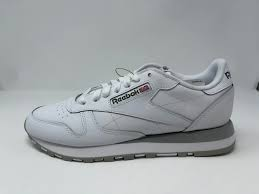

Image with white background
------------------------------------------------------------------------------


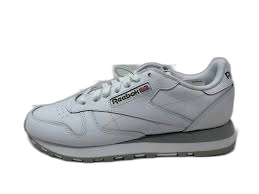

Image with bounding rectangle
------------------------------------------------------------------------------


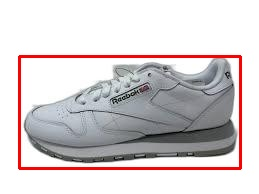

Image resized to correct resolution
------------------------------------------------------------------------------


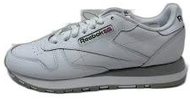

Predicted shoe brand:
reebok
Predicted shoe model:
club c


In [31]:

#STEP 1

#open image and use rembg to remove background
input_image = Image.open("testimages/reebok_club_c.jpeg") #Change image name to image to be tested

#display original image
print("Original Image to be classified")
print("------------------------------------------------------------------------------")

display(input_image)
removed_bg = remove(input_image)
removed_bg = removed_bg.convert('RGBA')

#create a pure white iamge the same size as original image
white_background = Image.new("RGBA", removed_bg.size, "WHITE")

#paste transparent image onto white background, lining it up with (0,0)
white_background.paste(removed_bg, (0, 0), removed_bg)

#get rid of alpha channel, now just has white background
final_image = white_background.convert("RGB")
final_image.save('temp_nobg.jpg')

print("Image with white background")
print("------------------------------------------------------------------------------")
display(final_image)



#STEP 2
# Read the image
image = cv2.imread('temp_nobg.jpg')

#convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#use inverse binary thresholding to make subject white, and white background black
_, thresh = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY_INV)

#finding the contours against black bg
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#largest contour will be the sohe
subject_contour = max(contours, key=cv2.contourArea)

#place bounding rectangle around shoe
x, y, w, h = cv2.boundingRect(subject_contour)

#making a copy for display purposes
imagecopy = image.copy()
#draw rectangle to display the bounding rectangle
cv2.rectangle(imagecopy, (x, y), (x+w, y+h), (0, 0, 255), 2)

# Save the image with the rectangle
cv2.imwrite('temprect.jpg', imagecopy)
temprect = Image.open('temprect.jpg')

print("Image with bounding rectangle")
print("------------------------------------------------------------------------------")
display(temprect)

#crop the image to the bounding rectangle
cropped_image = image[y:y+h, x:x+w]

#save the cropped image
cv2.imwrite('tempbound.jpg', cropped_image)



#STEP 3
def resize_with_padding(image_path, target_size):
    image = Image.open(image_path)

    # Calculate the aspect ratio of the image and the target size
    original_aspect = image.width / image.height
    new_aspect = target_size[0] / target_size[1]

    # Resize the image to fit within the target size while maintaining aspect ratio
    if original_aspect > new_aspect:
        # Image is wider than target aspect ratio
        new_height = int(target_size[0] / original_aspect)
        image = image.resize((target_size[0], new_height), Image.ANTIALIAS)
    else:
        # Image is taller than target aspect ratio
        new_width = int(target_size[1] * original_aspect)
        image = image.resize((new_width, target_size[1]), Image.ANTIALIAS)

    # Create a new image with white background
    new_image = Image.new("RGB", target_size, "white")
    new_image.paste(image, ((target_size[0] - image.width) // 2, (target_size[1] - image.height) // 2))

    return new_image


target_size = (190, 100)  
resized_image = resize_with_padding("tempbound.jpg", target_size)
print("Image resized to correct resolution")
print("------------------------------------------------------------------------------")
display(resized_image)
resized_image.save("tempresized.jpg")  




#STEP 4

#code to manually test new images one at a time
#need to resise and turn image to tensor
additional_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])



#replace with name of image
single_image = Image.open("tempresized.jpg")

single_image = additional_transform(single_image).float()
#necissary for single image because need to add extra dimension for batch size to make equivalent to other tensors
single_image = single_image.unsqueeze_(0)

#if using cuda need this
#single_image = single_image.to(device) 

model.eval()
#takes out the gradient computation which is unnecssisary on all testing
with torch.no_grad():
    output_result = model(single_image)

predicted_class_index = torch.argmax(output_result, dim=1).item()

print("Predicted shoe brand:")
print(class_names_dict[predicted_class_index][0])
print("Predicted shoe model:")
print(class_names_dict[predicted_class_index][1])